In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach
from obspy.imaging.source import plot_radiation_pattern

from matplotlib.patches import Rectangle
import matplotlib.patches

client = Client("IRIS")

In [15]:
def waveforms(start, end, adjtime):
    st_raw = client.get_waveforms("XB", "ELYSE", "02", "B*", start-(adjtime/2), end+adjtime, attach_response=True)
    st_disp = st_raw.copy()
    st_disp.remove_response(output='DISP')
    st_disp.filter('bandpass',freqmin=0.125, freqmax=1.0,corners=4, zerophase=True)
    return st_disp

def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

def uvw2enz(st,angles):
    BAz = angles[0]
    Pincd = angles[1]
    Sincd = angles[2]
    
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU),np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])
    
    hhe = stENZ[0].data
    hhn = stENZ[1].data
    hhz = stENZ[2].data

    #hhT,hhR = rotate(hhe,hhn,BAz)
    #head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    #head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    #phhQ,phhL = rotate(hhn,hhz,Pincd)
    #shhQ,shhL = rotate(hhn,hhz,Sincd)
    #head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    #head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    hhT,hhR = rotate(trE,trN,BAz)
    head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    phhQ,phhL = rotate(trR,trZ,Pincd)
    shhQ,shhL = rotate(trR,trZ,Sincd)
    head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    stALL = Stream(traces=[trL,trQ,trT])
    
    return stALL

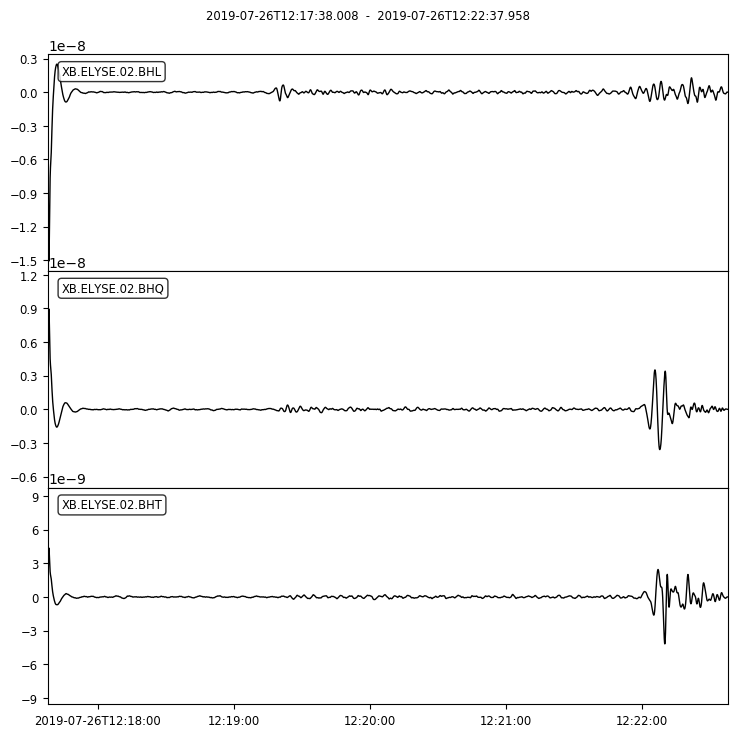

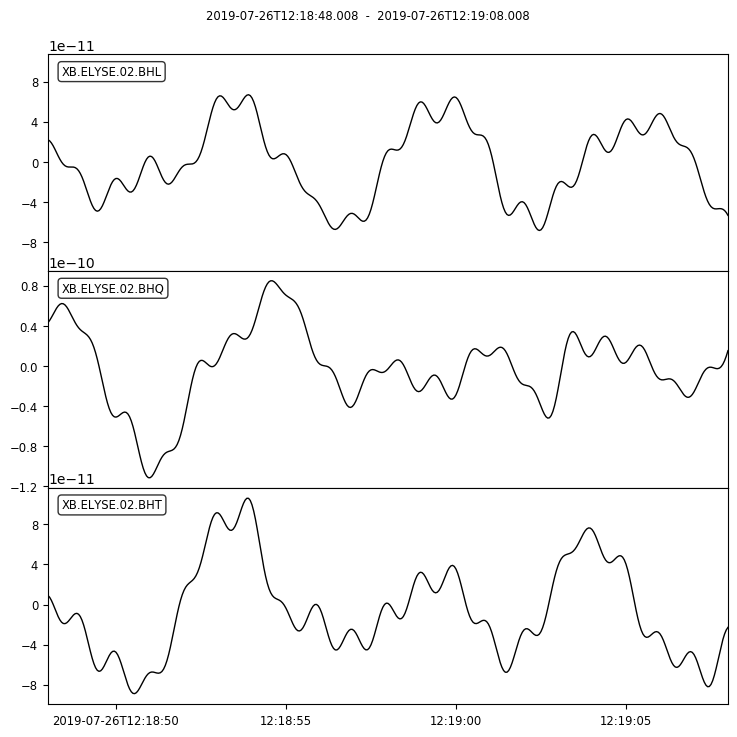

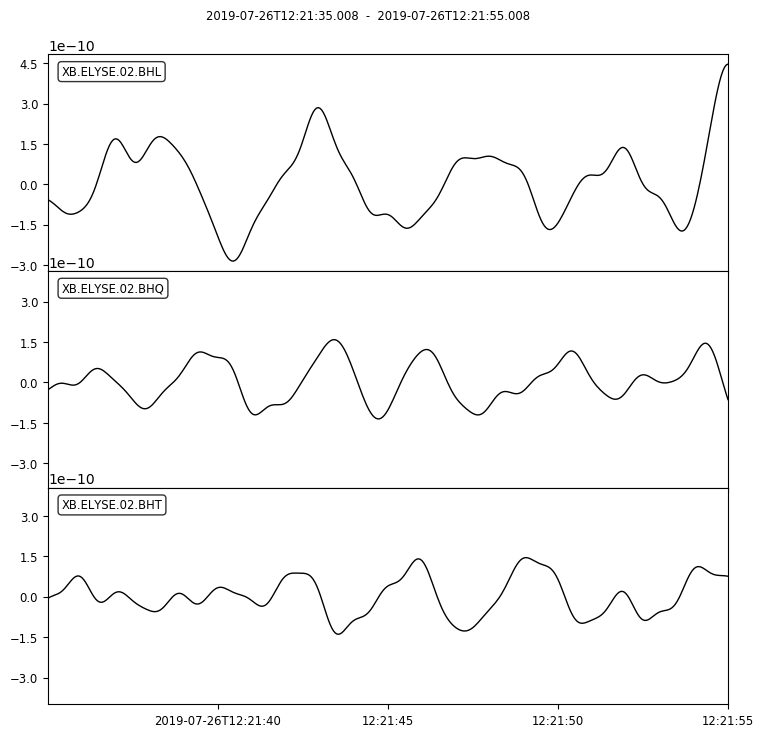

Noise on L (P) comp:  3.72766541198e-11
Noise on T (SH) comp:  7.41646973043e-11
Noise on Q (SV) comp:  7.03300592195e-11


In [42]:
P235b = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
S235b = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

n235b = waveforms(P235b, P235b, 200)
ang_235b = [254,25.5,23.2]

sENZ = uvw2enz(n235b,ang_235b)
sENZ.plot();

sliced_P = sENZ.slice(P235b-30,P235b-10)
sliced_P.plot();

sliced_S = sENZ.slice(S235b-30,S235b-10)
sliced_S.plot();

std_l = sliced_P[0].std()
std_t = sliced_S[1].std()
std_q = sliced_S[2].std()


print('Noise on L (P) comp: ',std_l)
print('Noise on T (SH) comp: ', std_t)
print('Noise on Q (SV) comp: ', std_q)

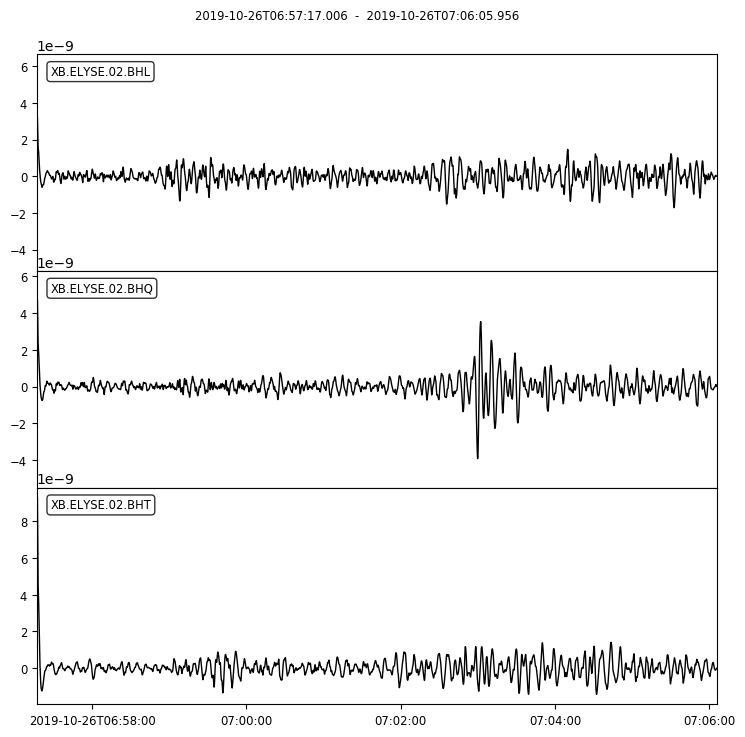

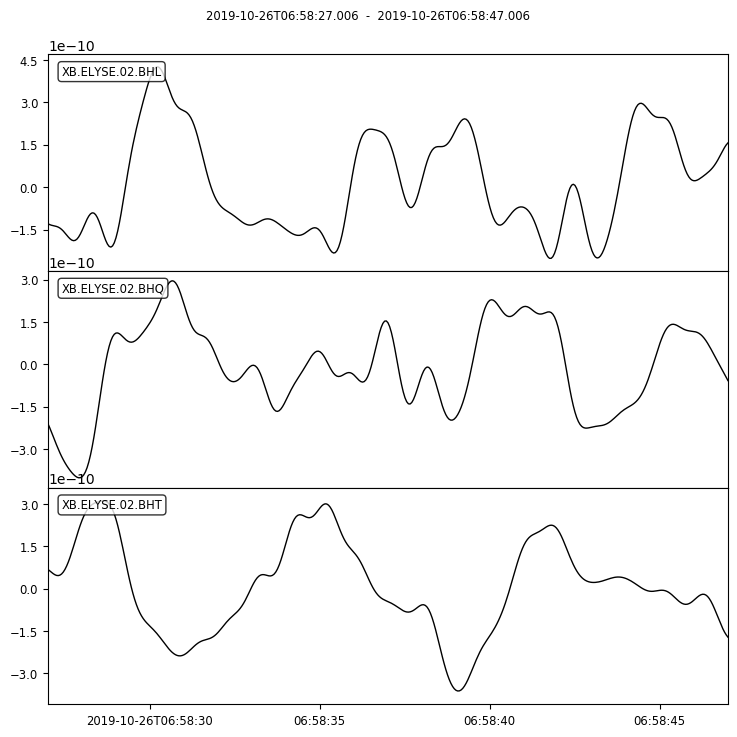

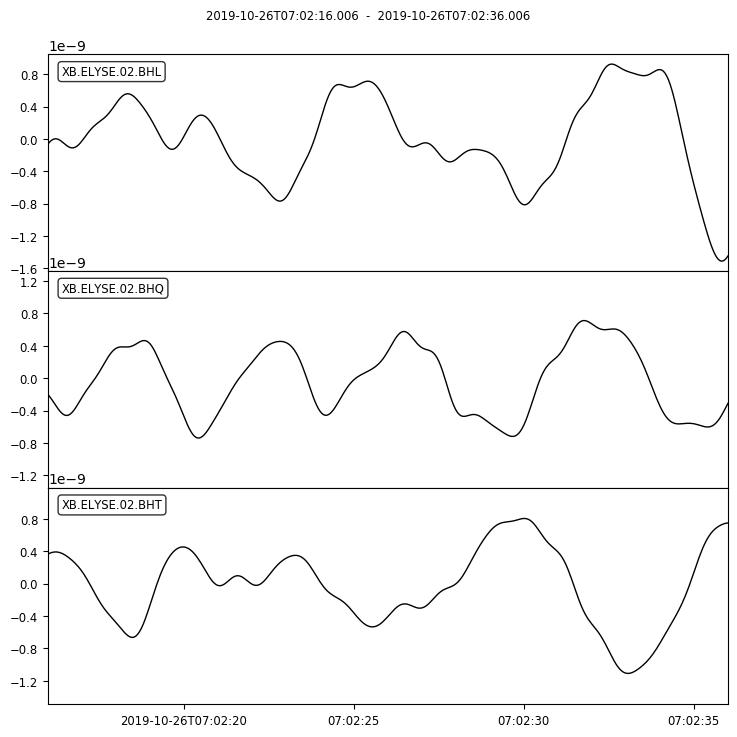

Noise on L (P) comp:  1.75029936928e-10
Noise on T (SH) comp:  4.25334680728e-10
Noise on Q (SV) comp:  4.78925817746e-10


In [44]:
P325a = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
S325a = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

n325a = waveforms(P325a, S325a, 200)
ang_325a = [303,24.4,22.4]

sENZ = uvw2enz(n325a,ang_325a)
sENZ.plot();

sliced_P = sENZ.slice(P325a-30,P325a-10)
sliced_P.plot();

sliced_S = sENZ.slice(S325a-30,S325a-10)
sliced_S.plot();

std_l = sliced_P[0].std()
std_t = sliced_S[1].std()
std_q = sliced_S[2].std()


print('Noise on L (P) comp: ',std_l)
print('Noise on T (SH) comp: ', std_t)
print('Noise on Q (SV) comp: ', std_q)

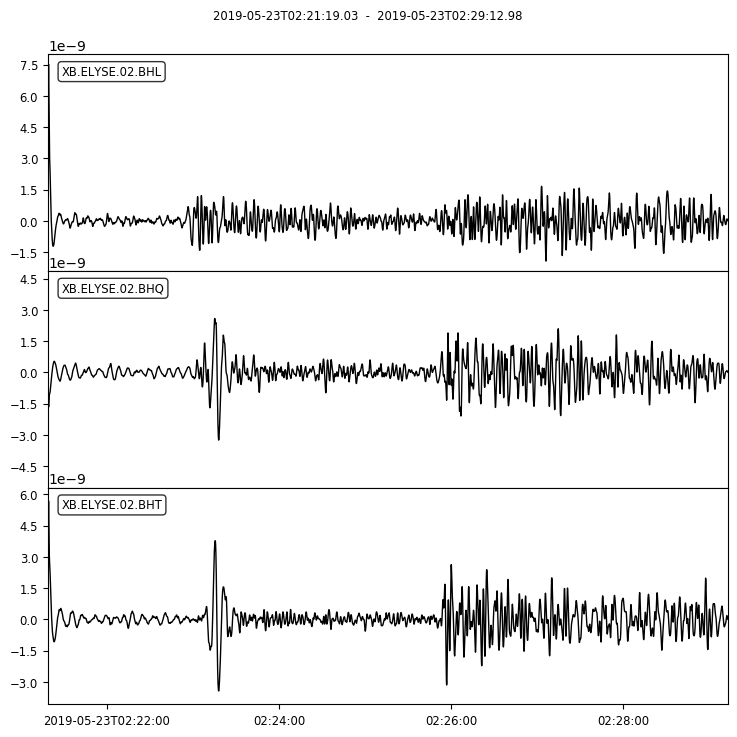

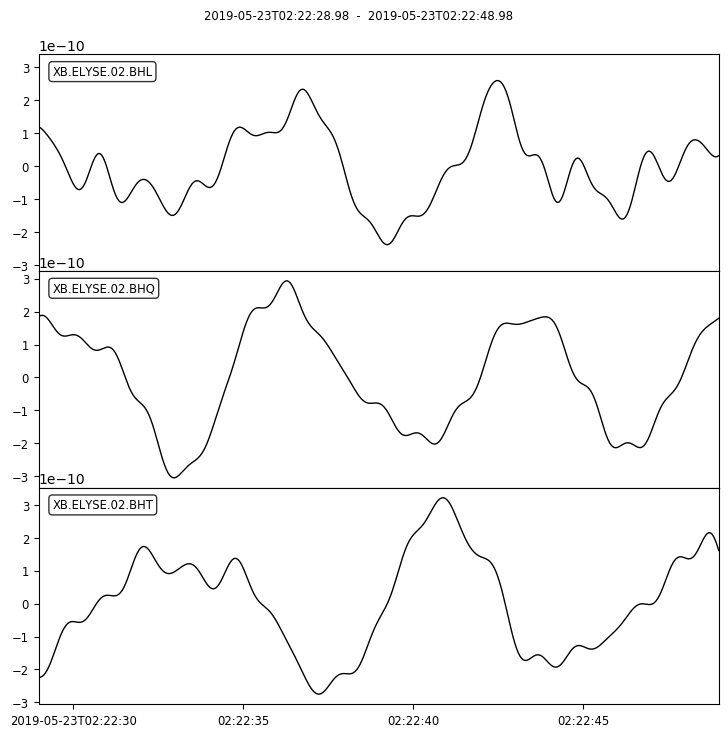

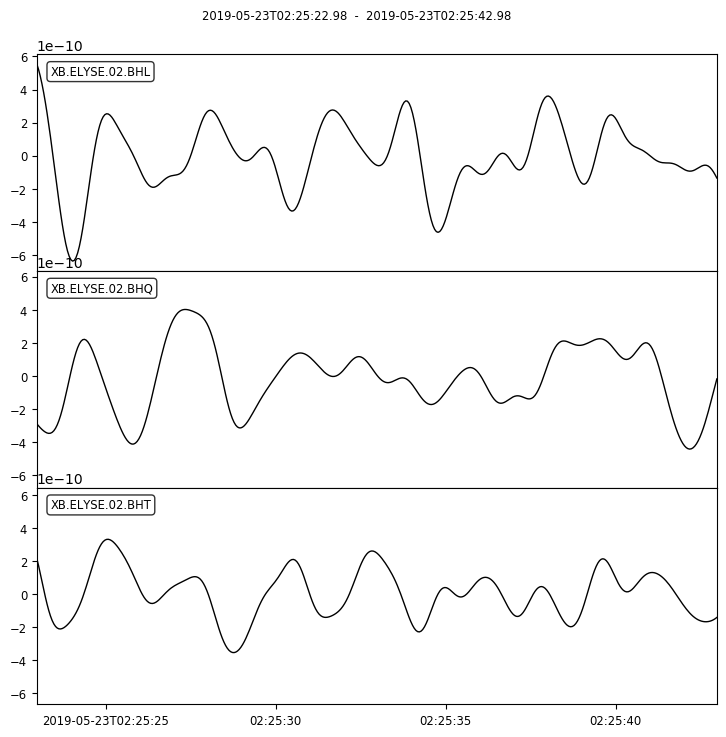

Noise on L (P) comp:  1.12893122405e-10
Noise on T (SH) comp:  2.01235611764e-10
Noise on Q (SV) comp:  1.4627858074e-10


In [45]:
P173a = UTCDateTime('2019-05-23T02:22:59')
S173a = UTCDateTime('2019-05-23T02:25:53')

n173a = waveforms(P173a, S173a, 200)
ang_173a = [270,25.9,23.4]

sENZ = uvw2enz(n173a,ang_173a)
sENZ.plot();

sliced_P = sENZ.slice(P173a-30,P173a-10)
sliced_P.plot();

sliced_S = sENZ.slice(S173a-30,S173a-10)
sliced_S.plot();

std_l = sliced_P[0].std()
std_t = sliced_S[1].std()
std_q = sliced_S[2].std()


print('Noise on L (P) comp: ',std_l)
print('Noise on T (SH) comp: ', std_t)
print('Noise on Q (SV) comp: ', std_q)

In [46]:
def waves_vanuatu(start, end, adjtime):
    # st_raw = client.get_waveforms("G", "SANVU", "00", "BH*", start-adjtime, end+adjtime, attach_response=True)
    st_raw = client.get_waveforms("AU", "NFK", "00", "BH*", start-adjtime, end+adjtime, attach_response=True)
    st_disp = st_raw.copy()
    st_disp.remove_response(output='DISP')
    st_disp.plot()
    return st_disp

def rot2enz_van(st,angles):
    BAz = angles[0]
    Pincd = angles[1]
    Sincd = angles[2]
    
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHE': E = trace.data
        elif channel == 'BHN': N = trace.data
        elif channel == 'BHZ': Z = trace.data
        else:
            print('Trace.channel is not BH1, BH2, or BHZ')
            return st

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])
    
    hhe = stENZ[0].data
    hhn = stENZ[1].data
    hhz = stENZ[2].data

    #hhT,hhR = rotate(hhe,hhn,BAz)
    #head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    #head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    #phhQ,phhL = rotate(hhn,hhz,Pincd)
    #shhQ,shhL = rotate(hhn,hhz,Sincd)
    #head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    #head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    hhT,hhR = rotate(trE,trN,BAz)
    head.channel = 'BHT'; trT = Trace(data=hhT, header=head)
    head.channel = 'BHR'; trR = Trace(data=hhR, header=head)
    
    phhQ,phhL = rotate(trR,trZ,Pincd)
    shhQ,shhL = rotate(trR,trZ,Sincd)
    head.channel = 'BHL'; trL = Trace(data=phhL, header=head)
    head.channel = 'BHQ'; trQ = Trace(data=shhQ, header=head)
    
    stALL = Stream(traces=[trL,trQ,trT])

    return stALL

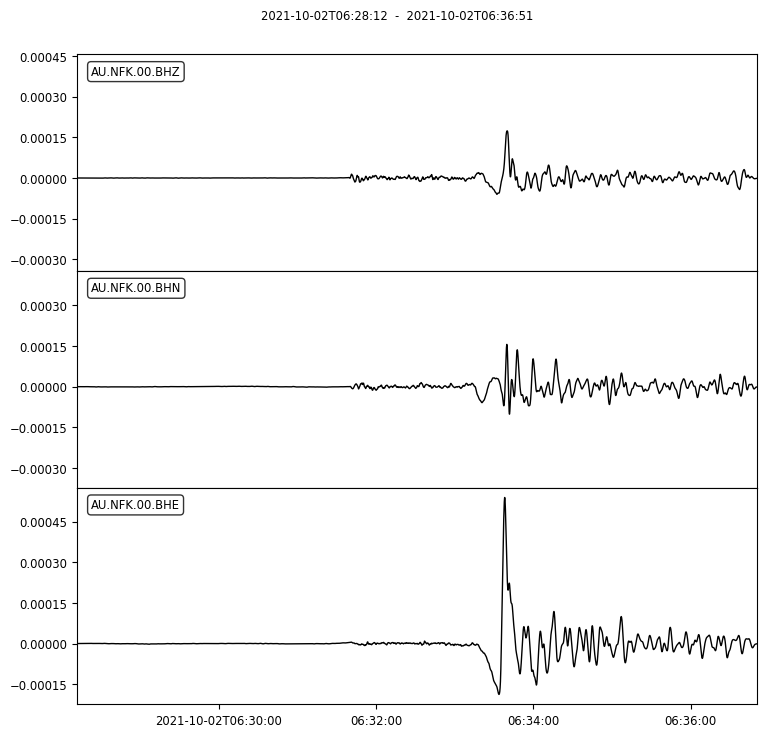

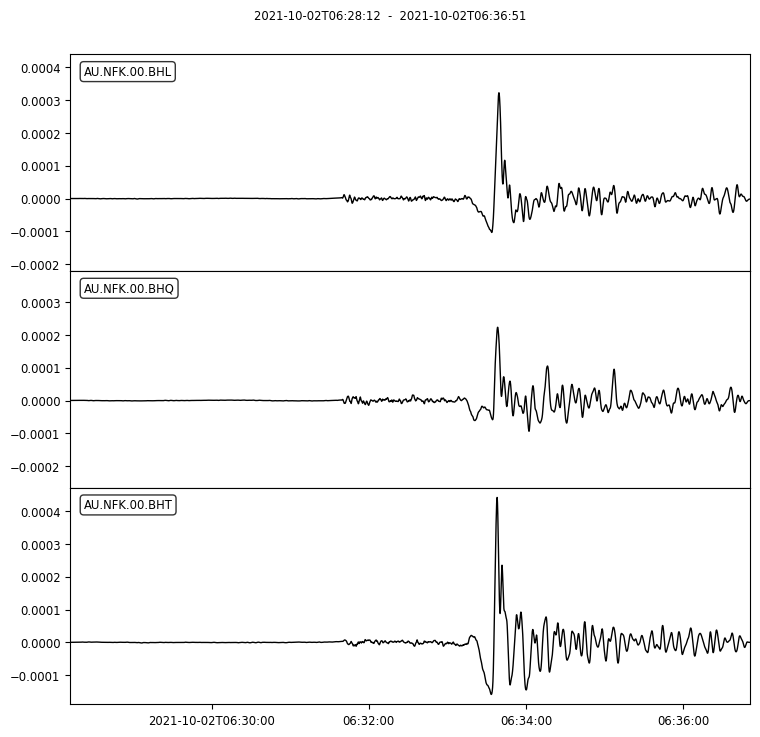

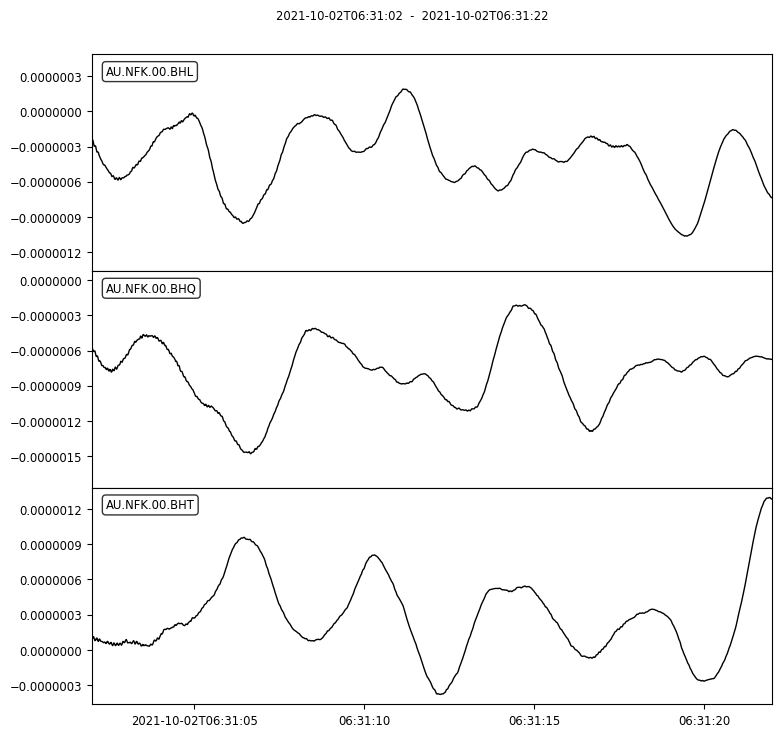

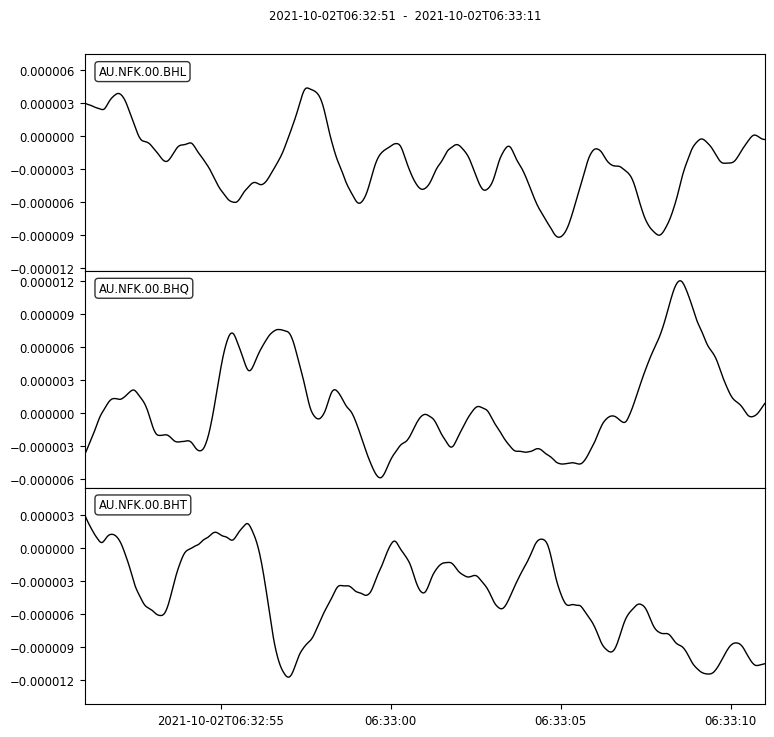

Noise on L (P) comp:  2.79149108105e-07
Noise on T (SH) comp:  4.11544257391e-06
Noise on Q (SV) comp:  3.9267185026e-06


In [50]:
arrival = UTCDateTime('2021-10-02T06:29:18')
PVAN = arrival + 134      #p-wave arrival
SVAN = arrival + 253        #s-wave arrival

nvan = waves_vanuatu(PVAN,SVAN,200)
ang_van = [40,32.67,35.02]

sTLQ = rot2enz_van(nvan,ang_van)
sTLQ.plot();

sliced_P = sTLQ.slice(PVAN-30,PVAN-10)
sliced_P.plot();

sliced_S = sTLQ.slice(SVAN-40,SVAN-20)
sliced_S.plot();

std_l = sliced_P[0].std()
std_t = sliced_S[1].std()
std_q = sliced_S[2].std()


print('Noise on L (P) comp: ',std_l)
print('Noise on T (SH) comp: ', std_t)
print('Noise on Q (SV) comp: ', std_q)

<IPython.core.display.Javascript object>


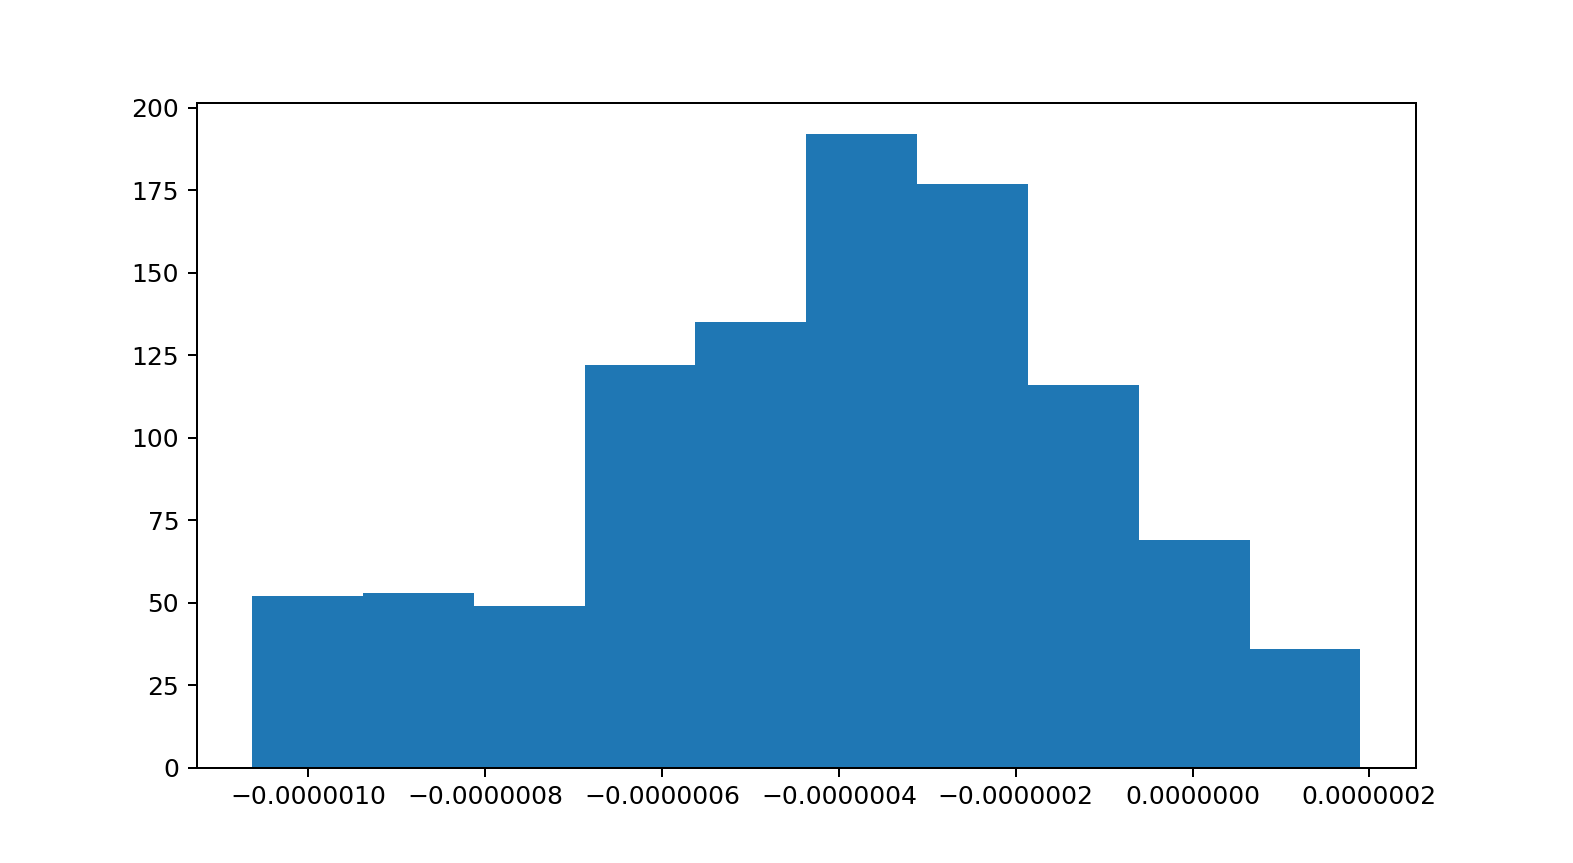

(array([  52.,   53.,   49.,  122.,  135.,  192.,  177.,  116.,   69.,   36.]),
 array([ -1.06365513e-06,  -9.38302854e-07,  -8.12950578e-07,
         -6.87598302e-07,  -5.62246025e-07,  -4.36893749e-07,
         -3.11541473e-07,  -1.86189197e-07,  -6.08369206e-08,
          6.45153556e-08,   1.89867632e-07]),
 <a list of 10 Patch objects>)

In [52]:
%matplotlib notebook
plt.hist(sliced_P[0])